# Import Library

This section imports the essential libraries and tools required for data analysis, preprocessing, and model development. Each library serves specific purposes: 
- **NumPy (`np`)**: For numerical computations and array operations. 
- **Pandas (`pd`)**: For data manipulation and analysis. 
- **Matplotlib (`plt`)**: For creating visualizations and plots. 
- **TensorFlow (`tf`)**: For building and training deep learning models. 
- **Scikit-learn**: 
    - **`compute_class_weight`**: To handle class imbalance in the data. 
    - **Preprocessing tools** (`StandardScaler`): For data scaling. 
    - **`train_test_split`**: For splitting datasets into training and testing sets. 
    - **`KMeans`**: For clustering the data. 
- **TensorFlow/Keras Components**: 
    - **Model Components** (`regularizers`): For designing and building neural network models.

In [323]:
import numpy as np
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers

In [324]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Load dataset

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Dataset_CP/gadget.csv')

## DATA PREPROCESSING

### Drop unnecessary columns

In [ ]:
data = data.drop(['Rating', 'Selling Price'], axis=1)

### Preprocess Memory column

In [ ]:
data['Memory'] = data['Memory'].str.extract('(\d+)', expand=False)
data['Memory'] = data['Memory'].str.strip().astype(float)

### Preprocess Storage column

In [ ]:
data['Storage'] = data['Storage'].str.extract('(\d+)', expand=False)
data['Storage'] = data['Storage'].str.strip().astype(float)

### Handle missing values with linear interpolation

In [ ]:
data[['Memory', 'Storage']] = data[['Memory', 'Storage']].interpolate(method='linear')

### Rename columns

In [ ]:
data.rename(columns={'Original Price': 'Price'}, inplace=True)

### Combine brand, model, and color into a single feature

In [ ]:
data['Brand'] = data['Brand'] + ' ' + data['Model'] + ' ' + data['Color']

### Convert price to INR

In [ ]:
exchange_inr = 100
data['Price'] = data['Price'] * exchange_inr
data['Price'] = data['Price'].astype(float)

### Drop unnecessary columns

In [ ]:
data.drop(columns=['Model', 'Color'], inplace=True)

### Normalize the price feature

In [ ]:
data['Price_normalized'] = (data['Price'] - data['Price'].min()) / (data['Price'].max() - data['Price'].min())

### Reduce the number of classes by clustering similar brands

In [ ]:
brand_counts = data['Brand'].value_counts()
min_samples = 5  
data = data[data['Brand'].isin(brand_counts[brand_counts >= min_samples].index)]

### Set Random Seed for Reproducibility

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

### Use KMeans clustering to group similar brands (set a reasonable number of clusters)

In [ ]:
n_clusters = 10  # Set number of clusters to match the expected classes (adjusted to 10)
kmeans = KMeans(n_clusters=n_clusters, init='k-means++', random_state=42)  
data['Brand_cluster'] = kmeans.fit_predict(data[['Price_normalized', 'Memory', 'Storage']])

### Ensure that no cluster has fewer than 2 samples

In [ ]:
cluster_counts = data['Brand_cluster'].value_counts()
valid_clusters = cluster_counts[cluster_counts > 1].index  
data = data[data['Brand_cluster'].isin(valid_clusters)]

### Rebuild features and labels after clustering

In [ ]:
features = data[['Price_normalized', 'Memory', 'Storage']].values
labels = data['Brand_cluster'].values  

### Features are normalized using StandardScaler to be on the same scale.

In [ ]:
scaler = StandardScaler()
features = scaler.fit_transform(features)

### Train-test split with stratification to ensure class balance

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    features, labels, test_size=0.2, random_state=42, stratify=labels
)

# Compute class weights to handle imbalanced classes
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

### Build a simpler model with dropout, batch normalization, and L2 regularization

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(128, activation='relu', kernel_initializer='glorot_uniform',
                        kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(n_clusters, activation='softmax', kernel_initializer='glorot_uniform')
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


### Compile the model

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0003),  
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])

### Add Early stopping dan Learning Rate Scheduler for got a good accuracy

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

history = model.fit(X_train, y_train,
                    epochs=100,
                    batch_size=8,
                    validation_split=0.2,
                    class_weight=class_weight_dict,
                    verbose=1,
                    callbacks=[early_stopping, lr_scheduler])

Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.1391 - loss: 1.9930 - val_accuracy: 0.2571 - val_loss: 2.2971 - learning_rate: 3.0000e-04
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2129 - loss: 1.6078 - val_accuracy: 0.3429 - val_loss: 2.2442 - learning_rate: 3.0000e-04
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3540 - loss: 1.3633 - val_accuracy: 0.3714 - val_loss: 2.1885 - learning_rate: 3.0000e-04
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5339 - loss: 1.1904 - val_accuracy: 0.5143 - val_loss: 2.1309 - learning_rate: 3.0000e-04
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5769 - loss: 1.0614 - val_accuracy: 0.5143 - val_loss: 2.0715 - learning_rate: 3.0000e-04
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6182 - loss: 0.9589 - val_accuracy: 0.6000 - val_loss: 2.0107 - learning_rate: 3.0000e-04
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6332

In [345]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9593 - loss: 0.1220
Test Accuracy: 95.45%


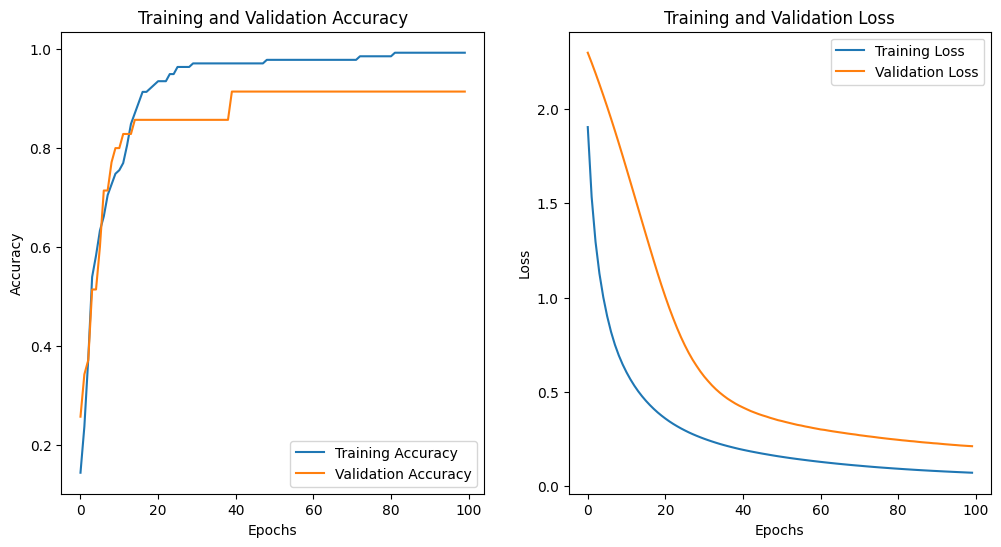

In [ ]:
# Plotting Training and Validation Accuracy
plt.figure(figsize=(12, 6))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


### Define a function to recommend phones based on the user's budget.

In [355]:
def recommend_phone(budget, tolerance=0.1, top_n=20):
    """
    Recommend phones based on budget, considering multiple brands and models.

    Args:
        budget (float): User's budget.
        tolerance (float): Price tolerance as percentage (default 10%).
        top_n (int): Number of top recommendations (default 20).

    Returns:
        pd.DataFrame: Recommended phones.
    """
    # Price range based on tolerance
    min_price = budget * (1 - tolerance)
    max_price = budget * (1 + tolerance)

    # Filter phones by price within the range
    recommendations = data[(data['Price'] >= min_price) & (data['Price'] <= max_price)]

    # Check if we have recommendations
    if not recommendations.empty:
        # Sort by specifications and price, but avoid recommending multiple phones of the same brand/model
        recommendations = recommendations.sort_values(
            by=['Memory', 'Storage', 'Price'], ascending=[False, False, True]
        )

        # Remove duplicates based on 'Brand' and 'Storage' to ensure variety in recommendations
        recommendations = recommendations.drop_duplicates(subset=['Brand', 'Storage'], keep='first')

        # Limit to the top_n recommendations
        recommendations = recommendations.head(top_n)

    # If no recommendations found, return empty dataframe
    if recommendations.empty:
        return pd.DataFrame(columns=['Brand', 'Price', 'Memory', 'Storage'])

    return recommendations[['Brand', 'Price', 'Memory', 'Storage']]

# Example usage
example_budget = 3000000  # Example budget
recommendations = recommend_phone(example_budget)
print(recommendations)


                                  Brand      Price  Memory     Storage
619   realme X3 SuperZoom  Glacier Blue  3199900.0     8.0  256.000000
626   realme X3 SuperZoom  Arctic White  3199900.0     8.0  256.000000
610   realme X3 SuperZoom  Glacier Blue  2999900.0     8.0  128.000000
693   realme X3 SuperZoom  Arctic White  2999900.0     8.0  128.000000
568   realme X3 SuperZoom  Arctic White  3199900.0     8.0   60.444444
1253            Apple iPhone 6s  Silver  2990000.0     2.0   32.000000
1377         Apple iPhone 6s  Rose Gold  2990000.0     2.0   32.000000
1258              Apple iPhone 7  Black  3150000.0     2.0   32.000000
1373         Apple iPhone 6s  Rose Gold  3199900.0     2.0   16.000000
1417               Apple iPhone 6  Gold  3078000.0     1.0   32.000000


### Save the model as h5 format

In [356]:
model.save('Gadget_fix.h5')